In [1]:
import numpy as np
import qiskit
import mitiq
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

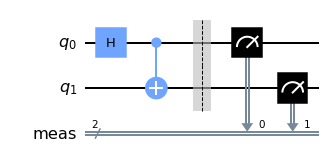

In [2]:
from qiskit.test.mock import FakeVigo

test_circuit = QuantumCircuit(2)

#backend = qiskit.Aer.get_backend("qasm_simulator")
backend = FakeVigo()

test_circuit.h(0)
test_circuit.cx(0,1)

test_circuit.measure_all()

job = qiskit.execute(test_circuit,backend,shots=4096)
results = job.result()
counts = results.get_counts()

test_circuit.draw(output='mpl')

In [3]:
print(counts)

{'11': 1844, '00': 1860, '01': 254, '10': 138}


In [4]:
def qiskit_multiqubit_executor(circuit, shots: 2000, state) -> float:
    # Use a depolarizing noise model.
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    counts = results.get_counts()
    #for x in counts:
    if state not in counts:
        return 0
    else:
        expval = counts[state] / shots
    return expval

In [5]:
qiskit_multiqubit_executor(test_circuit,2000,'00')

0.447

In [6]:
def zero_str(num_zeros):
    zero_string = ''
    x = 0
    while x < num_zeros:
        zero_string = zero_string + '0'
        x += 1
    return zero_string

num_qubits = int(test_circuit.width()/2)

num_bits=2**num_qubits
state_list = []

for x in range(0,num_bits):
    if x <= num_bits + 1:
        compare = len(bin(num_bits)[2:]) - len(bin(x)[2:])
        state_list.append(zero_str(compare-1) + bin(x)[2:])

state_list

['00', '01', '10', '11']

In [7]:
prob_1 = 0

for x in state_list:
    if x[0] == '1':
        prob_1 += qiskit_multiqubit_executor(test_circuit,2000,x)

print(prob_1)

print(qiskit_multiqubit_executor(test_circuit,2000,'10') + qiskit_multiqubit_executor(test_circuit,2000,'11'))

0.5025000000000001
0.5025000000000001


In [8]:
a = 1

num_qubits = 2

num_bits=2**num_qubits
state_list = []

# for x in range(0,num_bits):
#     if x <= num_bits + 1:
#         compare = len(bin(num_bits)[2:]) - len(bin(x)[2:])
#         state_list.append(zero_str(compare-1) + bin(x)[2:])

for x in range(0,num_bits):
    compare = len(bin(num_bits)[2:]) - len(bin(x)[2:])
    state_list.append(zero_str(compare-1) + bin(x)[2:])

print(state_list)

prob_1 = 0

for x in state_list:
    if x[a] == '1':
        prob_1 += qiskit_multiqubit_executor(test_circuit,2000,x)

prob_1

['00', '01', '10', '11']


0.5125000000000001

In [9]:
def prob1_spesific_qubit(circuit,shots,qubit):
    prob1 =  0
    for x in state_list:
        if x[qubit] == '1':
            prob1 += qiskit_multiqubit_executor(circuit,shots,x)
    return prob1

In [10]:
prob1_spesific_qubit(test_circuit,2000,0)

0.5025000000000001

In [11]:
from functools import partial

qiskit_executor_partial = partial(qiskit_multiqubit_executor, shots=2000, state='00')
mitiq.execute_with_zne(test_circuit,qiskit_executor_partial)

0.4469999999999996

In [12]:
def zne_prob(input_shots, input_state):
    temp = partial(qiskit_multiqubit_executor, shots=input_shots, state=input_state)
    return mitiq.execute_with_zne(test_circuit,temp)

In [13]:
zne_prob(8192,'10')

0.04309082031249997

In [14]:
def prob1_spesific_qubit_zne(shots,qubit):
    prob1 = 0
    for x in state_list:
        if x[qubit] == '1':
            prob1 += zne_prob(shots, x)
    return prob1

In [15]:
prob1_spesific_qubit_zne(2000,1)

0.5109999999999996

In [16]:
prob1_spesific_qubit_zne(2000,0)

0.5004999999999996

In [17]:
def z_expval(shots,site):
    return 2*prob1_spesific_qubit_zne(shots,site) - 1

In [18]:
z_expval(2000,1)

0.02199999999999913

In [19]:
z_expval(2000,0)

0.018999999999999462

In [20]:
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [21]:
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

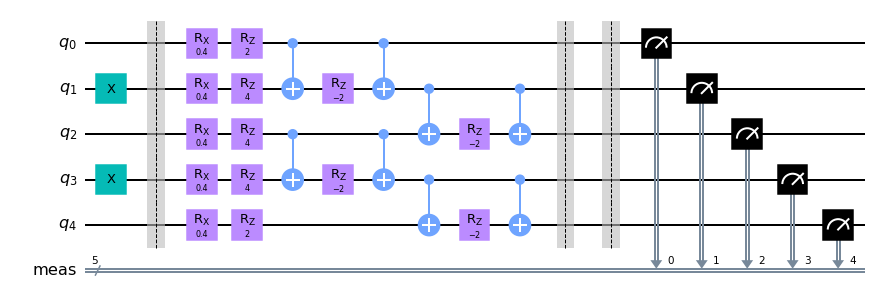

In [22]:
Trotter_circuit[1].draw(output='mpl')

In [23]:
#have to change the default circuit mitiq uses, and add time spesification
def zne_prob(input_shots, input_state,t):
    temp = partial(qiskit_multiqubit_executor, shots=input_shots, state=input_state)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp) #used to be test_circuit

zne_prob(2000,'00001',1)

0.020500000000000036

In [24]:
num_qubits = int(Trotter_circuit[0].width()/2)

num_bits=2**num_qubits
state_list = []

# for x in range(0,num_bits):
#     if x <= num_bits + 1:
#         compare = len(bin(num_bits)[2:]) - len(bin(x)[2:])
#         state_list.append(zero_str(compare-1) + bin(x)[2:])

for x in range(0,num_bits):
    compare = len(bin(num_bits)[2:]) - len(bin(x)[2:])
    state_list.append(zero_str(compare-1) + bin(x)[2:])

def prob1_spesific_qubit_zne(shots,qubit,t):
    prob1 = 0
    for x in state_list:
        if x[qubit] == '1':
            prob1 += zne_prob(shots, x, t)
    return prob1

In [25]:
prob1_spesific_qubit_zne(100,2,1)

0.03999999999999998

In [26]:
def z_expval(shots,site,t):
    return 2*prob1_spesific_qubit_zne(shots,site,t) - 1

In [27]:
z_expval(100,4,1)

-0.8200000000000003

In [28]:
z_expval(100,0,19)

-0.3200000000000005

In [29]:
z0_expval = []

for x in range(0,len(Trotter_circuit)):
    z0_expval.append(z_expval(100,0,x))

In [30]:
z0_expval

[-0.92,
 -0.9000000000000004,
 -0.9000000000000004,
 -0.6799999999999995,
 -0.15999999999999792,
 -0.5400000000000005,
 -0.8400000000000022,
 -0.20000000000000073,
 0.17999999999999972,
 0.17999999999999883,
 -0.38000000000000367,
 0.6200000000000001,
 0.8400000000000007,
 0.29999999999999916,
 0.3599999999999992,
 -0.10000000000000098,
 -0.400000000000002,
 0.5200000000000022,
 -0.2000000000000004,
 0.04000000000000048]

In [31]:
z_expval_dict = {}

for y in range(0,num_qubits):
    z_expval_dict.update({y:[]})
    for x in range(0,len(Trotter_circuit)):
        z_expval_dict[y].append(z_expval(1000,y,x))

In [32]:
z_expval_dict

{0: [-0.9580000000000001,
  -0.8960000000000002,
  -0.7639999999999997,
  -0.6919999999999995,
  -0.3959999999999988,
  -0.46599999999999986,
  -0.14999999999999958,
  -0.14400000000000035,
  0.06399999999999917,
  -0.13600000000000245,
  0.10399999999999854,
  0.06199999999999739,
  0.18599999999999772,
  0.40399999999999947,
  0.6280000000000006,
  -1.3322676295501878e-15,
  -0.02800000000000069,
  -0.024000000000000132,
  -0.06400000000000039,
  -0.2820000000000007],
 1: [0.9519999999999991,
  0.4719999999999973,
  0.5379999999999991,
  0.27399999999999847,
  0.15799999999999859,
  -0.38200000000000134,
  -0.08400000000000019,
  -0.13599999999999957,
  -0.7060000000000013,
  -0.6140000000000008,
  -0.7720000000000016,
  -0.30999999999999983,
  -0.5180000000000007,
  -0.5020000000000007,
  -0.5380000000000009,
  -0.38400000000000056,
  -0.3220000000000006,
  -0.05799999999999961,
  -0.10000000000000075,
  -0.03800000000000048],
 2: [-0.98,
  -1.202000000000001,
  -0.6499999999999992,

In [33]:
t=np.linspace(0,TT,NN)
l=np.linspace(1,5,5)
tt, ll = np.meshgrid(t, l)

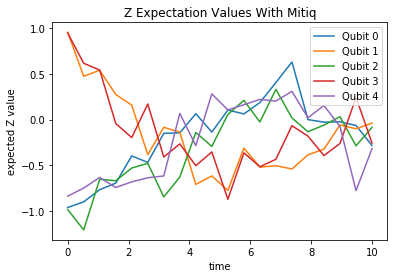

In [34]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(t, z_expval_dict[0], label='Qubit 0')
ax.plot(t, z_expval_dict[1], label='Qubit 1')
ax.plot(t, z_expval_dict[2], label='Qubit 2')
ax.plot(t, z_expval_dict[3], label='Qubit 3')
ax.plot(t, z_expval_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values With Mitiq")
ax.legend()

In [35]:
z_expval_no_mitiq_dict = {}

for y in range(0,num_qubits):
    z_expval_no_mitiq_dict.update({y:[]})
    for x in range(0,len(Trotter_circuit)):
        z_expval_no_mitiq_dict[y].append(2*prob1_spesific_qubit(Trotter_circuit[x],100,y)-1)

In [36]:
z_expval_no_mitiq_dict

{0: [-0.92,
  -0.84,
  -0.84,
  -0.8200000000000001,
  -0.6599999999999999,
  -0.5599999999999999,
  -0.3599999999999999,
  -0.1599999999999998,
  2.220446049250313e-16,
  0.17999999999999994,
  0.2400000000000002,
  0.26000000000000023,
  0.2400000000000002,
  0.20000000000000018,
  0.16000000000000014,
  0.0,
  -0.09999999999999964,
  -0.1599999999999997,
  -0.21999999999999975,
  -0.21999999999999975],
 1: [0.9000000000000001,
  0.7000000000000002,
  0.4400000000000004,
  0.20000000000000018,
  0.040000000000000036,
  -0.09999999999999964,
  -0.28,
  -0.41999999999999993,
  -0.45999999999999996,
  -0.52,
  -0.48,
  -0.43999999999999995,
  -0.43999999999999995,
  -0.48,
  -0.54,
  -0.43999999999999995,
  -0.3599999999999999,
  -0.2999999999999998,
  -0.23999999999999977,
  -0.21999999999999975],
 2: [-1,
  -0.9,
  -0.78,
  -0.8,
  -0.8200000000000001,
  -0.6199999999999999,
  -0.6599999999999999,
  -0.5,
  -0.33999999999999986,
  -0.29999999999999993,
  -0.19999999999999984,
  -0.219

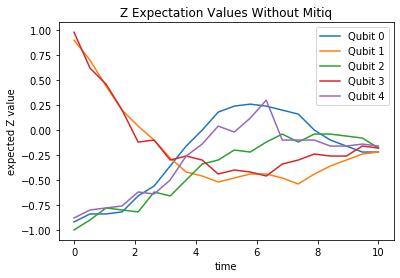

In [37]:
fig,ax = plt.subplots()
ax.plot(t, z_expval_no_mitiq_dict[0], label='Qubit 0')
ax.plot(t, z_expval_no_mitiq_dict[1], label='Qubit 1')
ax.plot(t, z_expval_no_mitiq_dict[2], label='Qubit 2')
ax.plot(t, z_expval_no_mitiq_dict[3], label='Qubit 3')
ax.plot(t, z_expval_no_mitiq_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Z Expectation Values Without Mitiq")
ax.legend()